# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.51KFile/s]


Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

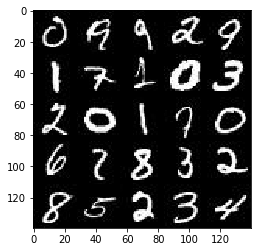

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

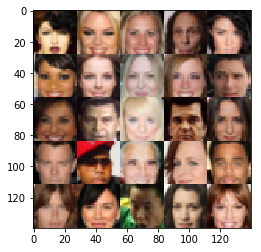

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    input_lr = tf.placeholder(tf.float32, name='input_lr')

    return input_real, input_z, input_lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())        
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # flatten
        flatten = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        return output, logits
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)        
        x1 = tf.maximum(alpha * x1, x1)
#         print (x1.shape)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         print (x2.shape)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
#         print (x3.shape)
        # 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        output = tf.tanh(logits)
#         print (output.shape)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real)*(1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
#     d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
#     g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()
#     saver = tf.train.Saver()
#     print('data_shape:', data_shape)
    
    n_numbers, image_width, image_height, image_channels = data_shape
#     image_mode = "RGB" if image_channels == 3 else "L"
    print('shape:', image_width,image_height,image_channels,data_image_mode)
    
    input_real, input_z, input_lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    
    steps = 0
    print_every = 20
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
#                 print(batch_images.shape)
                
                # Run optimizers
                sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_lr: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_lr: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, input_lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images, input_lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
            
#             print (epoch_i)
    
    print ('Finish Train')
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

shape: 28 28 1 L
Epoch 1/2... Discriminator Loss: 0.4006... Generator Loss: 5.9249
Epoch 1/2... Discriminator Loss: 0.5886... Generator Loss: 3.6251
Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 2.6009
Epoch 1/2... Discriminator Loss: 0.5634... Generator Loss: 2.2909
Epoch 1/2... Discriminator Loss: 0.3960... Generator Loss: 3.3737


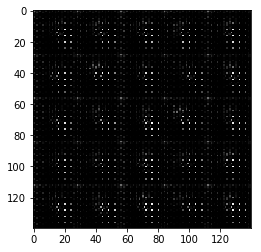

Epoch 1/2... Discriminator Loss: 1.6554... Generator Loss: 0.5321
Epoch 1/2... Discriminator Loss: 0.6363... Generator Loss: 2.3715
Epoch 1/2... Discriminator Loss: 0.6799... Generator Loss: 2.3153
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 2.5395


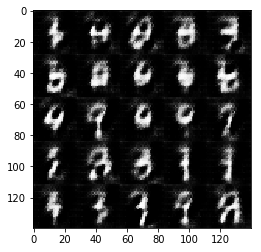

Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 3.7400
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 1.5809
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 1.0701
Epoch 1/2... Discriminator Loss: 1.3299... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 1.2765


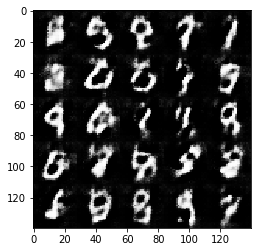

Epoch 1/2... Discriminator Loss: 1.4987... Generator Loss: 0.4573
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.5951
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 1.3296
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.6088
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 1.3619


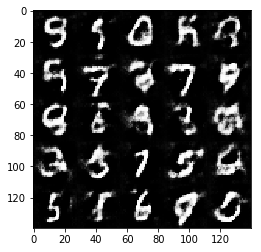

Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 1.0781
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 1.0965... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 1.1704


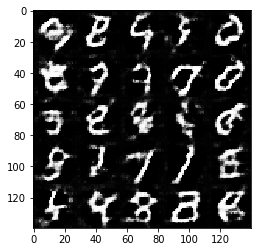

Epoch 1/2... Discriminator Loss: 1.1386... Generator Loss: 1.3853
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 1.4480
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.4226


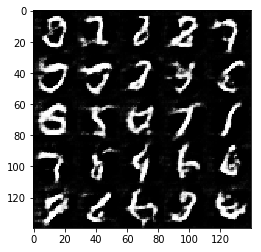

Epoch 1/2... Discriminator Loss: 1.1053... Generator Loss: 0.8382
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 1.4310
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 1.9708


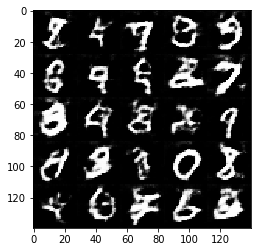

Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 1.2318
Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.6767... Generator Loss: 0.3383
Epoch 1/2... Discriminator Loss: 1.5585... Generator Loss: 1.9936


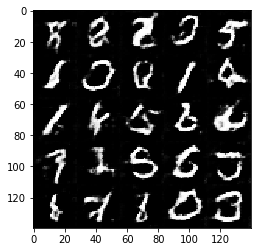

Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 1.3156
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 1.5151... Generator Loss: 1.9205
Epoch 1/2... Discriminator Loss: 1.5340... Generator Loss: 0.4787


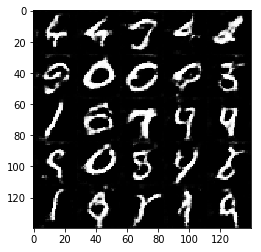

Epoch 1/2... Discriminator Loss: 1.0784... Generator Loss: 1.1148
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 1.0132... Generator Loss: 1.5080
Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 1.0447
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 1.1827


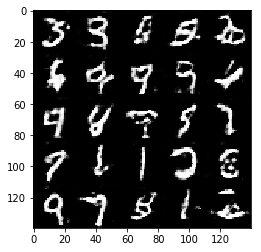

Epoch 2/2... Discriminator Loss: 0.9372... Generator Loss: 1.4277
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.7464
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 1.6539... Generator Loss: 0.3909


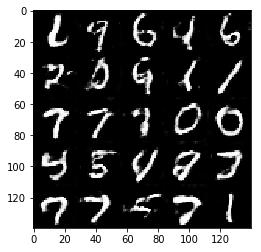

Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 1.2220
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 1.0133
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 0.6545
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 1.0447


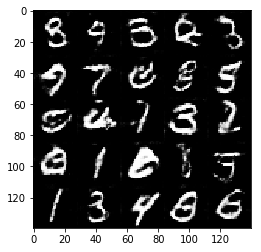

Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 0.7519
Epoch 2/2... Discriminator Loss: 1.9955... Generator Loss: 2.8132
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 1.3376


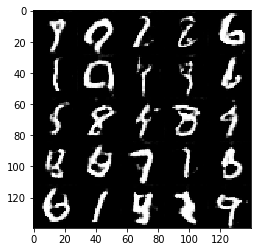

Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 2.7148
Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 1.4163
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 0.8840
Epoch 2/2... Discriminator Loss: 1.6863... Generator Loss: 0.4102
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.6570


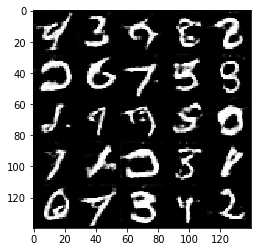

Epoch 2/2... Discriminator Loss: 0.9334... Generator Loss: 1.1021
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.4143
Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 1.0184
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 0.9915


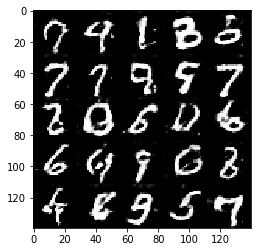

Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 0.7248
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 1.4813


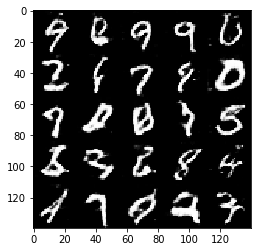

Epoch 2/2... Discriminator Loss: 1.5742... Generator Loss: 0.4096
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 0.7060... Generator Loss: 1.5176
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 2.4479
Epoch 2/2... Discriminator Loss: 0.7976... Generator Loss: 1.1947


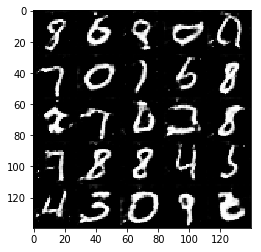

Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 1.5377
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 1.5181
Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 1.0276
Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.8481


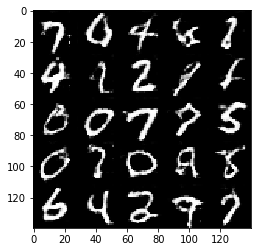

Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 0.8531
Finish Train


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
# print (mnist_dataset.get_batches)
# print (mnist_dataset.shape)
# print (mnist_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

shape: 28 28 3 RGB
Epoch 1/1... Discriminator Loss: 3.7744... Generator Loss: 0.0981
Epoch 1/1... Discriminator Loss: 1.9824... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.5765


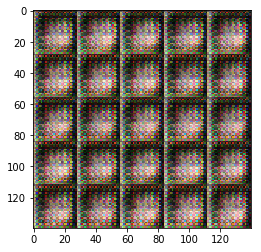

Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 1.8225
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.6528... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.8074


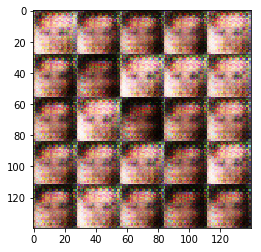

Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.7211... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 0.4962


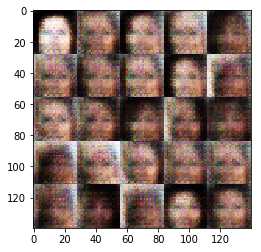

Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.5562


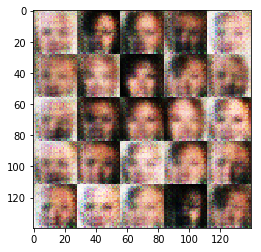

Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6626


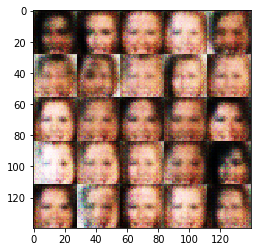

Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.6961


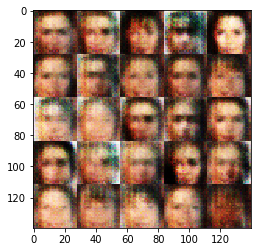

Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7002


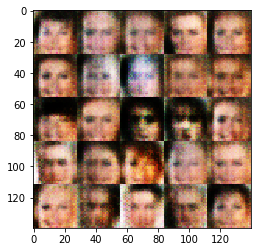

Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.7424


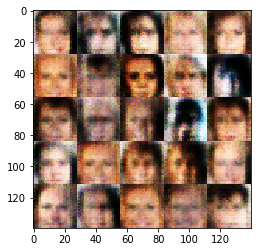

Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.7375


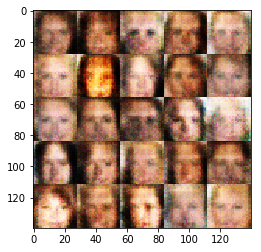

Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6603


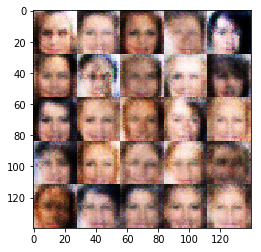

Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.8177


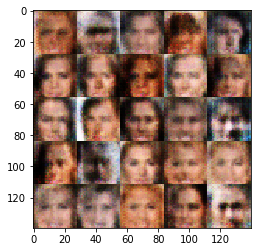

Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7321


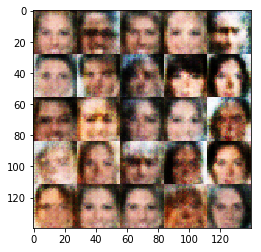

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8260


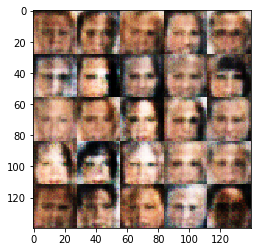

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7200


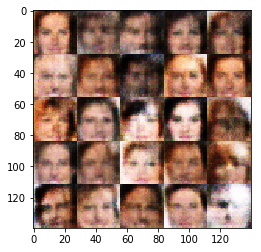

Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7497


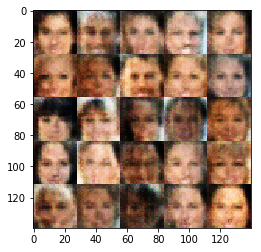

Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7279


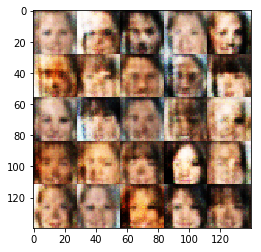

Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7982


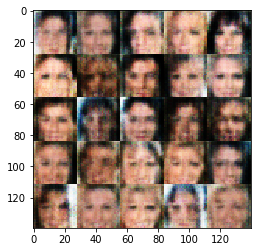

Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7233


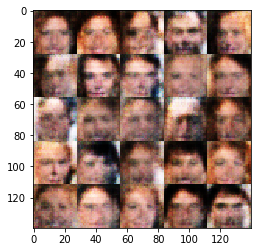

Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7205


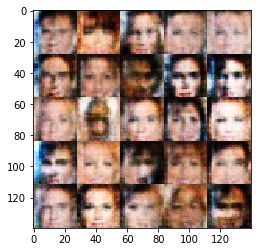

Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7272


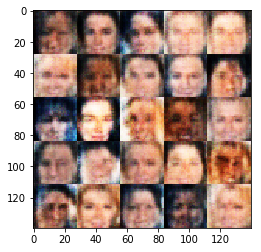

Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7631


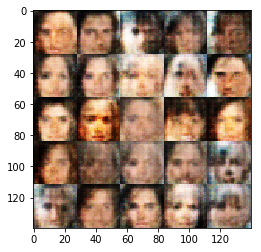

Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6869


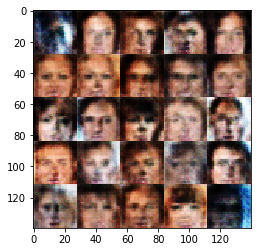

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7917


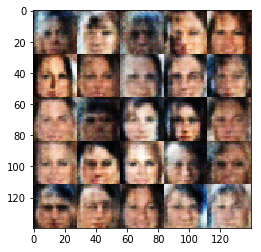

Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7747


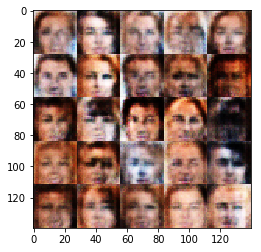

Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8641


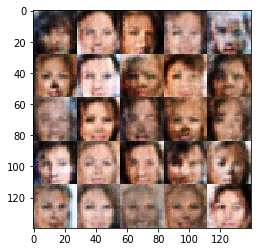

Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7852


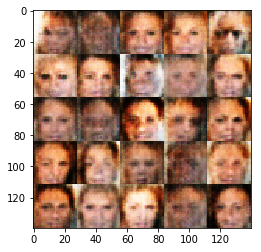

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7552


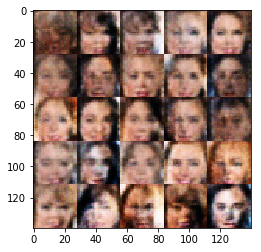

Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7461


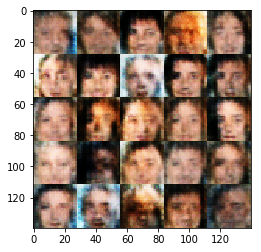

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7820


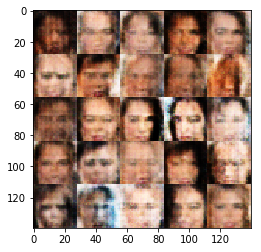

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6624


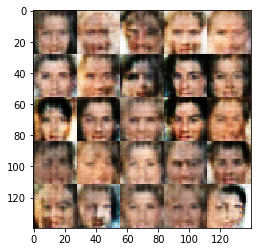

Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7520


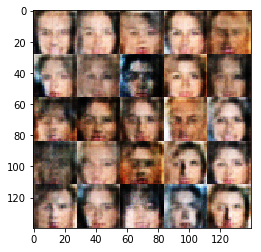

Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.8711


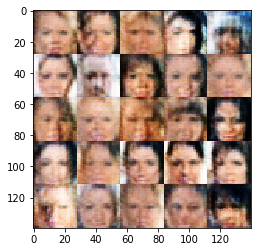

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7363


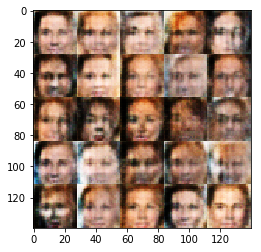

Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6588


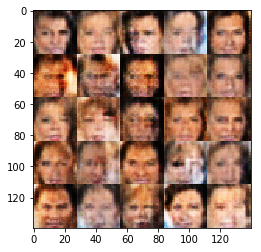

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7843


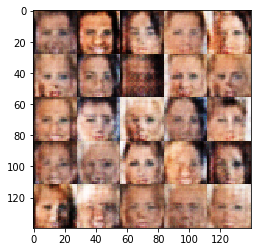

Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7087


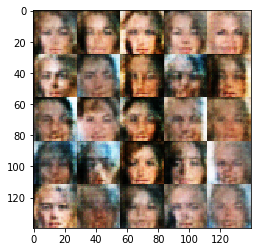

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7661


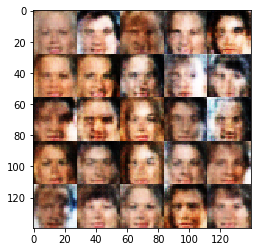

Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7803


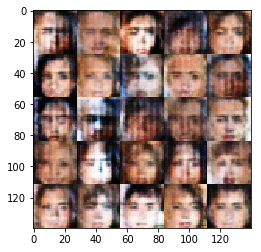

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7646


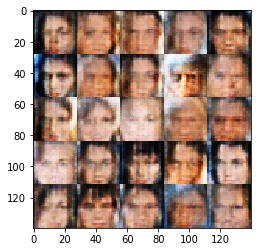

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7211


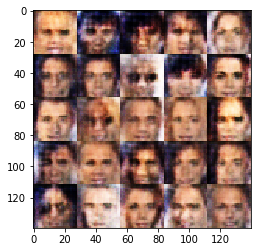

Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7365


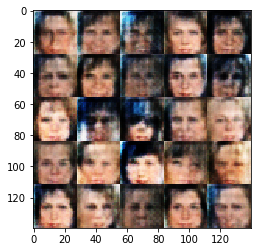

Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7537


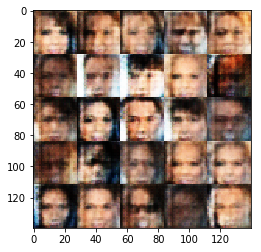

Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.8253


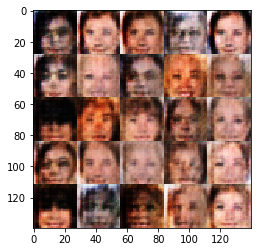

Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7869


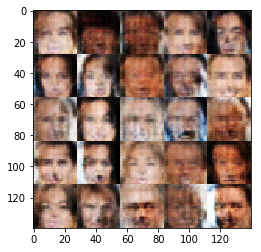

Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7143


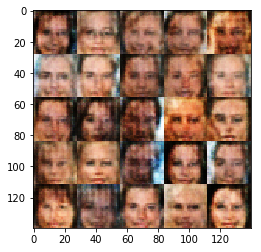

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7097


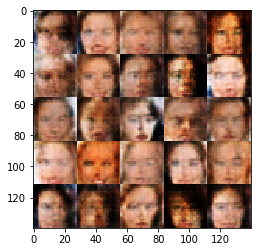

Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8002


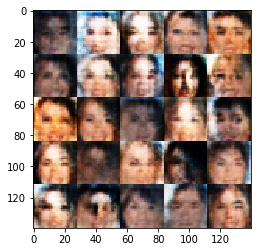

Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7200


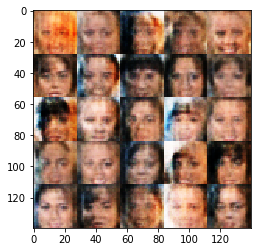

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8338


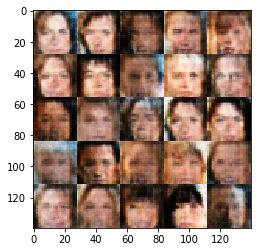

Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7956


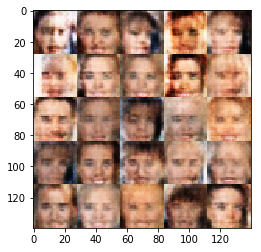

Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7823


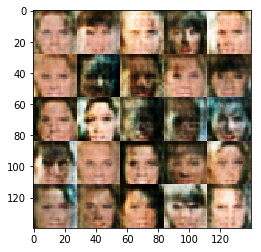

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7639


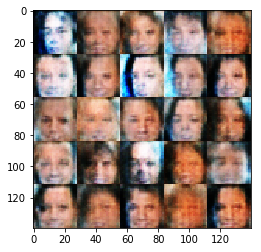

Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7671


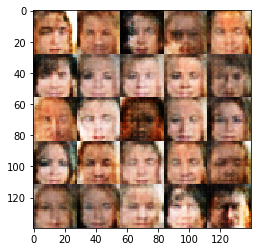

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7332


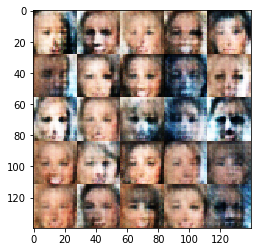

Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7868


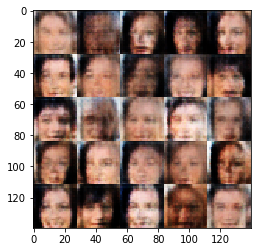

Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7165


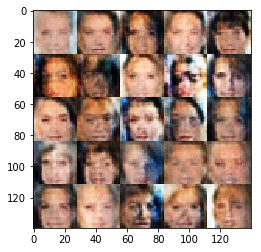

Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7206


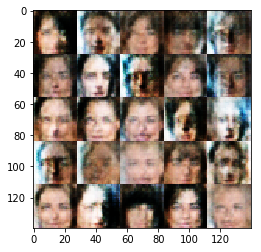

Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6918


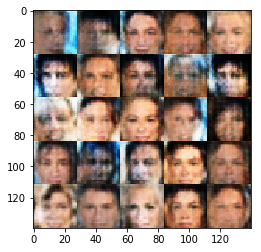

Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.8085


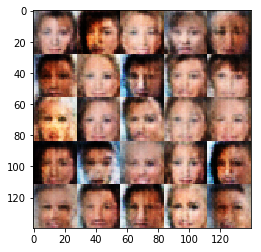

Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8092


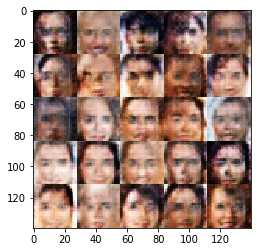

Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8123


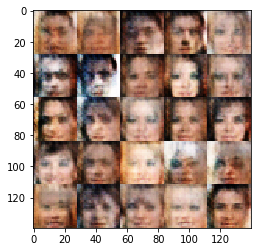

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7036


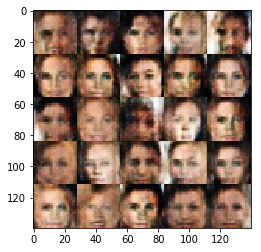

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7651


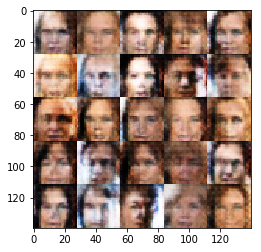

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7518
Finish Train


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。